<a href="https://colab.research.google.com/github/EliasEconomou/DataMining1-Sentiment-Analysis/blob/main/DataMining1_Sentiment_Analysis.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# **Importing Libraries and Reading Datafile**

In [1]:
import numpy as np
import pandas as pd
from sklearn.model_selection import train_test_split
import re
import sys
import os.path
#!pip install --user -U nltk
import nltk
nltk.download('punkt')
nltk.download('stopwords')
from nltk.corpus import stopwords
from nltk.tokenize import word_tokenize
from nltk.probability import FreqDist
from wordcloud import WordCloud
import math
from itertools import chain
import matplotlib.pyplot as plt
from datetime import datetime

[nltk_data] Downloading package punkt to /root/nltk_data...
[nltk_data]   Unzipping tokenizers/punkt.zip.
[nltk_data] Downloading package stopwords to /root/nltk_data...
[nltk_data]   Unzipping corpora/stopwords.zip.


In [2]:
# Options
pd.options.mode.chained_assignment = None

In [3]:
# Reading data file
filePath = "./drive/MyDrive/ColabNotebooks/eclass_all_with_sentiment_v2.pkl"
fileExists = os.path.exists(filePath)
if fileExists:
  allRowsDF = pd.read_pickle(filePath)
else:
  print('Enter data file path:')
  filePath = input()
  allRowsDF = pd.read_pickle(filePath)
allRowsDF.head()

,id,user_name,user_location,user_description,user_created,user_followers,user_friends,user_favourites,user_verified,date,text,hashtags,source,retweets,favorites,is_retweet,sentiment
0,1340539111971516416,Rachel Roh,"La Crescenta-Montrose, CA",Aggregator of Asian American news; scanning di...,2009-04-08 17:52:46,405,1692,3247,False,2020-12-20 06:06:44,Same folks said daikon paste could treat a cyt...,['PfizerBioNTech'],Twitter for Android,0,0,False,NEU
1,1338158543359250433,Albert Fong,"San Francisco, CA","Marketing dude, tech geek, heavy metal & '80s ...",2009-09-21 15:27:30,834,666,178,False,2020-12-13 16:27:13,While the world has been on the wrong side of ...,NaN,Twitter Web App,1,1,False,NEG
2,1337858199140118533,eli🇱🇹🇪🇺👌,Your Bed,"heil, hydra 🖐☺",2020-06-25 23:30:28,10,88,155,False,2020-12-12 20:33:45,#coronavirus #SputnikV #AstraZeneca #PfizerBio...,"['coronavirus', 'SputnikV', 'AstraZeneca', 'Pf...",Twitter for Android,0,0,False,NEU
3,1337855739918835717,Charles Adler,"Vancouver, BC - Canada","Hosting ""CharlesAdlerTonight"" Global News Radi...",2008-09-10 11:28:53,49165,3933,21853,True,2020-12-12 20:23:59,"Facts are immutable, Senator, even when you're...",NaN,Twitter Web App,446,2129,False,NEU
4,1337854064604966912,Citizen News Channel,NaN,Citizen News Channel bringing you an alternati...,2020-04-23 17:58:42,152,580,1473,False,2020-12-12 20:17:19,Explain to me again why we need a vaccine @Bor...,"['whereareallthesickpeople', 'PfizerBioNTech']",Twitter for iPhone,0,0,False,NEG


# **Preprocessing and Cleaning Data**

In [4]:
# Choose a subset of the full dataset's tweets
numOfRows = allRowsDF.shape[0]
# We'll use all tweets for analyzing data and maybe use a subset later in
# training if that process is very slow
percentage = 100
initDF = allRowsDF.iloc[:int(percentage*0.01*numOfRows)]
print("Chosen number of tweets is {} - {}% of the given dataset.".format(initDF.shape[0], percentage))

Chosen number of tweets is 228207 - 100% of the given dataset.


In [5]:
# About to start cleaning dataframe, let's keep the initial one
df = initDF.copy()

# Remove punctuation, links, hashtags, new lines etc, using regular expressions
df["text"] = df["text"].replace('\.|,|\?|!|:|\(|\)|%|\$','', regex=True)
df["text"] = df["text"].replace('\n|\t','', regex=True)
df["text"] = df["text"].replace(r'(http\S+)|(www\S+)|(#\S+)|(&\S+)|(@\S+)','', regex=True)
df["text"] = df["text"].replace('(\s-\s)','', regex=True)

# Remove emojis by encoding - decoding into ascii, resulting in ignoring emojis
df["text"] = df["text"].apply(lambda x: x.encode('ascii', 'ignore').decode('ascii'))

# Convert text to lowercase
df["text"] = df["text"].str.lower()

# Remove stopwords like 'i','is','you', etc
stopWords = list(stopwords.words('english'))
stopWords.remove("why")
stopWords.remove("how")
stopWords.remove("against")
stopWords.remove("again")
stopWords.remove("not")
stopWords.append("'ve")
stopWords.append("'re")
stopWords.append("'s")
stopWords.append("``")
stopWords.append("''")

# if "'d" in stopWords:
#   print(True)
# else:
#   print(False)
df["text"] = df["text"].apply(word_tokenize)
df["text"] = df["text"].apply(lambda words: [word for word in words if word not in stopWords])

# Remove any unnecessary spaces
df["text"] = df["text"].replace(' +', ' ', regex=True)

# Remove rows with empty data
df.text.dropna()

print("Dataframe has {} tweets after cleaning.".format(df.shape[0]))

Dataframe has 228207 tweets after cleaning.


# **Analyzing Data**

**0.   Functions**

In [6]:
# Counts the appearances of sentiments in a dictionary, then plots a pie
def plot_sentiments(dataframe,title):
  sentimentDict = {'POS' : 0, 'NEG' : 0, 'NEU' : 0}
  for sentiment in dataframe["sentiment"]:
    sentimentDict[sentiment] += 1

  labels = sentimentDict.keys()
  sizes = sentimentDict.values()
  explode = [0, 0, 0.07]

  fig1, ax1 = plt.subplots()
  ax1.pie(sizes, explode=explode, labels=labels, autopct='%1.1f%%',
          shadow=True, startangle=-25)
  ax1.axis('equal')
  plt.title(label=title,
            loc="left",
            pad='20.0',
            backgroundcolor='lime')
  plt.show()

**1.   Distribution of sentiments**

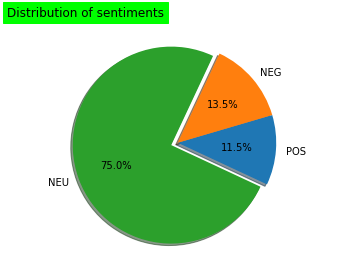

In [7]:
plot_sentiments(df,"Distribution of sentiments")


**2.   Most used words**

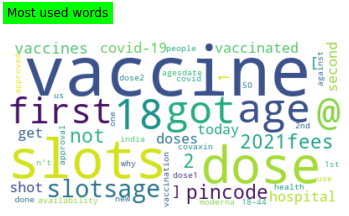

In [8]:
# Plot a wordcloud for most used words in dataset
wordList = list(chain.from_iterable(list(df["text"])))
fdist = FreqDist(wordList)
#print(fdist.most_common(50))

wordcloud = WordCloud(max_words=50,
                      background_color='white',
                      contour_color='black',
                      contour_width=4).generate_from_frequencies(fdist)


plt.imshow(wordcloud, interpolation='bilinear')
plt.axis('off')
plt.title(label='Most used words',
          loc="left",
          pad='25.0',
          backgroundcolor='lime')
plt.show()

**3.   Most used words by tweet sentiment**

In [9]:
# Group by sentiment and plot wordclouds for most used words in every sentiment
groupBySent = df.groupby('sentiment')


In [10]:
POSgroup = groupBySent.get_group('POS')
NEGgroup = groupBySent.get_group('NEG')
NEUgroup = groupBySent.get_group('NEU')

In [11]:
POSList = list(chain.from_iterable(list(POSgroup["text"])))
POSfdist = FreqDist(POSList)
NEGList = list(chain.from_iterable(list(NEGgroup["text"])))
NEGfdist = FreqDist(NEGList)
NEUList = list(chain.from_iterable(list(NEUgroup["text"])))
NEUfdist = FreqDist(NEUList)

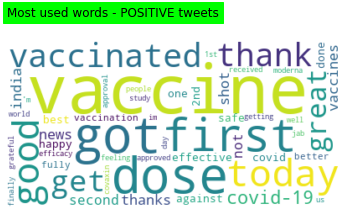

In [12]:
POScloud = WordCloud(max_words=50,
                      background_color='white',
                      contour_color='black',
                      contour_width=4).generate_from_frequencies(POSfdist)

plt.imshow(POScloud, interpolation='bilinear')
plt.axis('off')
plt.title(label='Most used words - POSITIVE tweets',
          loc="left",
          pad='25.0',
          backgroundcolor='lime')
plt.show()

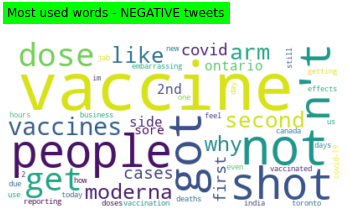

In [13]:
NEGcloud = WordCloud(max_words=50,
                      background_color='white',
                      contour_color='black',
                      contour_width=4).generate_from_frequencies(NEGfdist)

plt.imshow(NEGcloud, interpolation='bilinear')
plt.axis('off')
plt.title(label='Most used words - NEGATIVE tweets',
          loc="left",
          pad='25.0',
          backgroundcolor='lime')
plt.show()

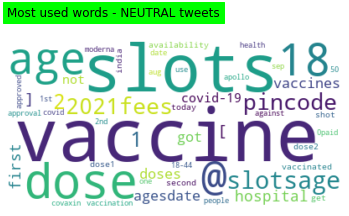

In [14]:
NEUcloud = WordCloud(max_words=50,
                      background_color='white',
                      contour_color='black',
                      contour_width=4).generate_from_frequencies(NEUfdist)

plt.imshow(NEUcloud, interpolation='bilinear')
plt.axis('off')
plt.title(label='Most used words - NEUTRAL tweets',
          loc="left",
          pad='25.0',
          backgroundcolor='lime')
plt.show()

**4.   Sentiments on astrazeneca / pfizer-moderna vaccines**

In [15]:
# Use the initial not cleaned dataframe for this one
tempDf = initDF.copy()

# Convert text to lowercase
tempDf["text"] = tempDf["text"].str.lower()

# Search for sub-strings and keep the rows
df1 = tempDf[tempDf["text"].str.contains("astrazeneca")]
df2 = tempDf[tempDf["text"].str.contains("pfizer|moderna|biontech")]

print(df1.shape,df2.shape)

(7477, 17) (59500, 17)


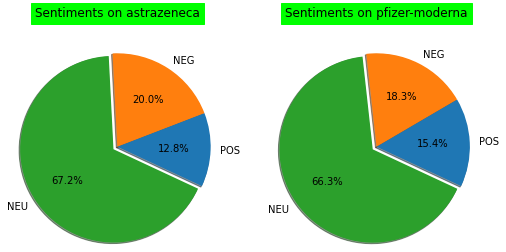

In [16]:
# Count the appearances of sentiments in a dictionary in each df
sentimentDict1 = {'POS' : 0, 'NEG' : 0, 'NEU' : 0}
for sentiment in df1["sentiment"]:
  sentimentDict1[sentiment] += 1

sentimentDict2 = {'POS' : 0, 'NEG' : 0, 'NEU' : 0}
for sentiment in df2["sentiment"]:
  sentimentDict2[sentiment] += 1

labels1 = sentimentDict1.keys()
sizes1 = sentimentDict1.values()
labels2 = sentimentDict2.keys()
sizes2 = sentimentDict2.values()
explode = [0, 0, 0.09]

fig = plt.figure()

ax1 = fig.add_axes([0, .2, .3, .5], aspect=1)
ax1.pie(sizes1, labels=labels1, radius = 1.8, autopct='%1.1f%%',
        shadow=True, startangle=-25, explode=explode)
ax2 = fig.add_axes([.6, .2, .3, .5], aspect=1)
ax2.pie(sizes2, labels=labels2, radius = 1.8, autopct='%1.1f%%',
        shadow=True, startangle=-25, explode=explode)
ax1.set_title(label="Sentiments on astrazeneca",
          pad='65.0',
          backgroundcolor='lime')
ax2.set_title(label="Sentiments on pfizer-moderna",
          pad='65.0',
          backgroundcolor='lime')
plt.show()


**5.   Tweets per month - Important dates**

In [17]:
dateDf = df.copy()

# Grouping by month
dateDf.index = pd.to_datetime(dateDf['date'],format='%Y-%m-%d %H:%M:%S')
groupMonth = dateDf.groupby(pd.Grouper(freq='m'))

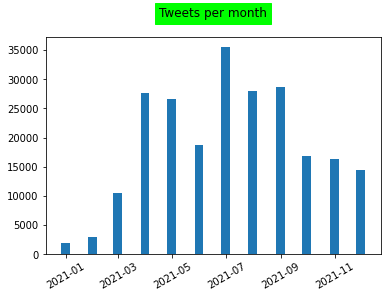

In [18]:
x = groupMonth.size().keys()
y = groupMonth.size()

plt.title(label="Tweets per month",
          pad='20.0',
          backgroundcolor='lime')
plt.bar(x, y, width = 10)
plt.xticks(rotation=30)

plt.show()


In [ ]:

# print(groupMonth.get_group("2021-07-31")["text"][800])
# print(groupMonth.get_group("2021-07-31")["sentiment"][800])


We can see more than 30000 people tweeted by the end of June to July (2021), probably because around that time vaccines get available in more and more countries and most importantly it becomes available to younger age groups (who use social media the most)

By examining the data we realise that a large group of people seems to understand the risks of COVID-19 and the importance of vaccines thus gets their first doses, while another group fights vaccines because of rising conspiracy theories and misinformation about side-effects.

In July 7 COVID-19 deaths surpass 4 million globally.


**6.   Sentiments by popular users**

In [88]:
popDf = df[df['user_followers'] > 500000]

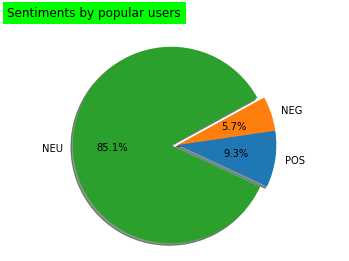

In [89]:
plot_sentiments(popDf,"Sentiments by popular users")

**7.   Sentiments on sputnik vaccine**

In [90]:
# Use the initial not cleaned dataframe for this one
tempDf = initDF.copy()

# Convert text to lowercase
tempDf["text"] = tempDf["text"].str.lower()

# Search for sub-strings and keep the rows
df1 = tempDf[tempDf["text"].str.contains("sputnik")]
df2 = tempDf[tempDf["text"].str.contains("johnson")]

print(df1.shape,df2.shape)

(17907, 17) (2212, 17)


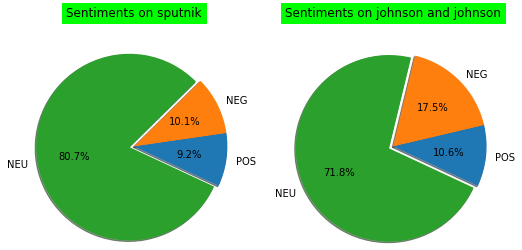

In [91]:
# Count the appearances of sentiments in a dictionary in each df
sentimentDict1 = {'POS' : 0, 'NEG' : 0, 'NEU' : 0}
for sentiment in df1["sentiment"]:
  sentimentDict1[sentiment] += 1

sentimentDict2 = {'POS' : 0, 'NEG' : 0, 'NEU' : 0}
for sentiment in df2["sentiment"]:
  sentimentDict2[sentiment] += 1

labels1 = sentimentDict1.keys()
sizes1 = sentimentDict1.values()
labels2 = sentimentDict2.keys()
sizes2 = sentimentDict2.values()
explode = [0, 0, 0.09]

fig = plt.figure()

ax1 = fig.add_axes([0, .2, .3, .5], aspect=1)
ax1.pie(sizes1, labels=labels1, radius = 1.8, autopct='%1.1f%%',
        shadow=True, startangle=-25, explode=explode)
ax2 = fig.add_axes([.6, .2, .3, .5], aspect=1)
ax2.pie(sizes2, labels=labels2, radius = 1.8, autopct='%1.1f%%',
        shadow=True, startangle=-25, explode=explode)
ax1.set_title(label="Sentiments on sputnik",
          pad='65.0',
          backgroundcolor='lime')
ax2.set_title(label="Sentiments on johnson and johnson",
          pad='65.0',
          backgroundcolor='lime')
plt.show()

In [ ]:
df